# Name: David Ryan
# Student ID: 0867284

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import seaborn as sns
from sklearn.cluster import FeatureAgglomeration
from sklearn.linear_model import PassiveAggressiveRegressor

## EDA

We start with a brief EDA to check for missing values and outliers.

In [2]:
df = pd.read_csv("./insurance.csv")
df.head()

age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

In [3]:
df.tail()

age  gender     bmi  children smoker     region  insurance_cost
1333   64  female  31.825         2     no  northeast     16069.08475
1334   64  female  26.885         0    yes  northwest     29330.98315
1335   64    male  26.410         0     no  northeast     14394.55790
1336   64    male  36.960         2    yes  southeast     49577.66240
1337   64    male  23.760         0    yes  southeast     26926.51440

Let's examine values in the categorical column `Species` first.

In [4]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [5]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

Now, let's check for missing values and outliers.

In [6]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

There are no obvious missing values. Let's also examine the basic statistics of the numerical attributes.

In [7]:
df.describe()

age          bmi     children  insurance_cost
count  1338.000000  1338.000000  1338.000000     1338.000000
mean     39.207025    30.663397     1.094918    13270.422265
std      14.049960     6.098187     1.205493    12110.011237
min      18.000000    15.960000     0.000000     1121.873900
25%      27.000000    26.296250     0.000000     4740.287150
50%      39.000000    30.400000     1.000000     9382.033000
75%      51.000000    34.693750     2.000000    16639.912515
max      64.000000    53.130000     5.000000    63770.428010

They all look OK. `children` has some values which are zero, however this is a perfectly valid value and would be of relevance in calculating insurance costs.

Next, let's check for outliers in the numerical columns. Based on the table above we can try to plot all numerical column except `insurance_cost` together.

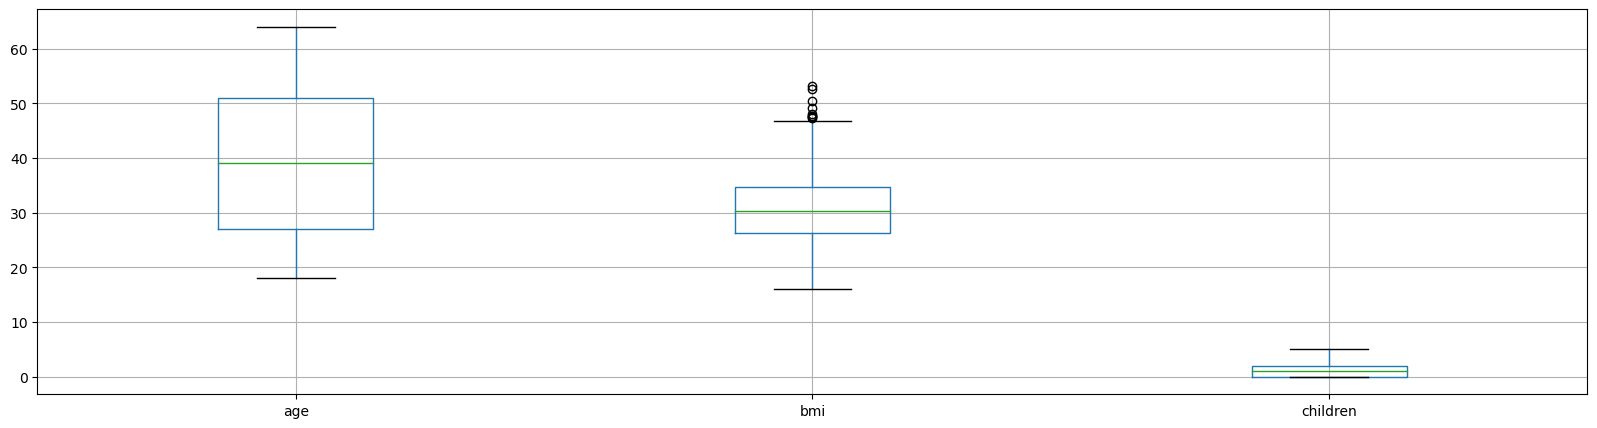

In [8]:
df.drop('insurance_cost', axis=1).boxplot(figsize=(20,5))
plt.show()

There are some outliers with the default settings for the boxplot function but they do not look like they need special treatement. Let's also take a look at the weight column.

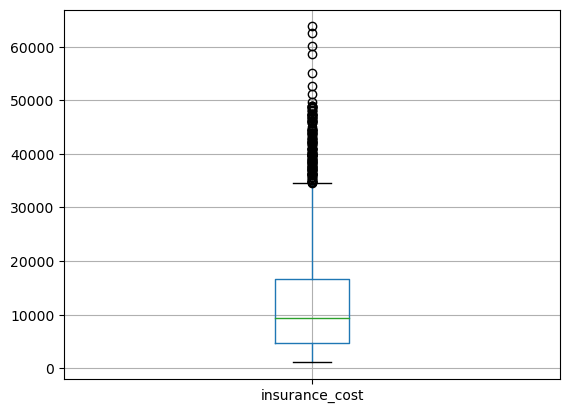

In [9]:
df.boxplot(column=['insurance_cost'])
plt.show()

Seems to be a lot of outliers in the `insurance_cost` column. Let's have a look at some of these values and see if we can gain any insights.

In [10]:
insurance_sorted = df.sort_values(by='insurance_cost', ascending=False).head(10)
insurance_sorted

age  gender     bmi  children smoker     region  insurance_cost
1079   54  female  47.410         0    yes  southeast     63770.42801
837    45    male  30.360         0    yes  southeast     62592.87309
1035   52    male  34.485         3    yes  northwest     60021.39897
458    31  female  38.095         1    yes  northeast     58571.07448
512    33  female  35.530         0    yes  northwest     55135.40209
1246   60    male  32.800         0    yes  southwest     52590.82939
363    28    male  36.400         1    yes  southwest     51194.55914
1336   64    male  36.960         2    yes  southeast     49577.66240
1221   59    male  41.140         1    yes  southeast     48970.24760
793    44  female  38.060         0    yes  southeast     48885.13561

In [11]:
insurance_sorted.describe()

age        bmi   children  insurance_cost
count  10.000000  10.000000  10.000000       10.000000
mean   47.000000  37.124000   0.800000    55130.961078
std    12.918548   4.693422   1.032796     5733.165542
min    28.000000  30.360000   0.000000    48885.135610
25%    35.750000  34.746250   0.000000    49981.886585
50%    48.500000  36.680000   0.500000    53863.115740
75%    57.750000  38.086250   1.000000    59658.817848
max    64.000000  47.410000   3.000000    63770.428010

A very crude glance at the samples with the highest `insurance_cost` correlate with above average `age` and `bmi` as well as all being labelled as `smoker`. This seems to track with what we would expect to be risk factors for (health?) insurance. So we will keep these samples and just make sure to scale them appropriately.

## Data Preparation

Next, we will replace the categorical columns `gender`, `smoker` and `region` with numerical columns. Since the labels in these columns do not have order, we will use `one-hot encoding` to do this.

In [12]:
df = pd.get_dummies(df, columns=['gender', 'smoker', 'region'], 
                        drop_first=True)

Let's examine the transformed dataset.

In [13]:
df.head()

age     bmi  children  insurance_cost  gender_male  smoker_yes  \
0   18  33.770         1      1725.55230            1           0   
1   18  34.100         0      1137.01100            1           0   
2   18  26.315         0      2198.18985            0           0   
3   18  38.665         2      3393.35635            0           0   
4   18  35.625         0      2211.13075            0           0   

   region_northwest  region_southeast  region_southwest  
0                 0                 1                 0  
1                 0                 1                 0  
2                 0                 0                 0  
3                 0                 0                 0  
4                 0                 0                 0

In [14]:
df.tail()

age     bmi  children  insurance_cost  gender_male  smoker_yes  \
1333   64  31.825         2     16069.08475            0           0   
1334   64  26.885         0     29330.98315            0           1   
1335   64  26.410         0     14394.55790            1           0   
1336   64  36.960         2     49577.66240            1           1   
1337   64  23.760         0     26926.51440            1           1   

      region_northwest  region_southeast  region_southwest  
1333                 0                 0                 0  
1334                 1                 0                 0  
1335                 0                 0                 0  
1336                 0                 1                 0  
1337                 0                 1                 0

In [15]:
preprocess_pipeline = make_pipeline(StandardScaler())

Now we can separate the columns into *target* and *predictors* and split the dataset into a training and test sets. 

In [16]:
y = df['insurance_cost']
X = df.drop('insurance_cost', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we will build another [main] pipeline which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we will attempt three different dimensionality reduction methods and we will let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using regression algorithms for selecting the best features. These regression algorithms can be different from the regression algorithm at the end of the main pipeline.

The main pipeline will take care for separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

### Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We will treat the method as a parameter and let the grid search pick the best of the three methods.

In [17]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute.

In [18]:
N_FEATURES_OPTIONS = [4, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.856:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=6), 'reduce_dim__n_features_to_select': 6, 'regresson__max_depth': 4}


The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Let's repeat the same experiment but with `LinearRegression` for training a regression model.

### Linear Regression Pipeline

In [19]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [20]:
N_FEATURES_OPTIONS = [4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS
    },
    {
        'reduce_dim': [FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.745:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4}


# Task 3: PassiveAggressiveRegressor

In [21]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', PassiveAggressiveRegressor())])

In [22]:
N_FEATURES_OPTIONS = [4, 6, 8]
C_OPTIONS = [0.0001, 0.001, 0.01, 0.1, 1, 100]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__C': C_OPTIONS,
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')), RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__C': C_OPTIONS,
    },
    {
        'reduce_dim': [FeatureAgglomeration()],
        'reduce_dim__n_clusters': N_FEATURES_OPTIONS,
        'regresson__C': C_OPTIONS,
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
PAR_best_params = search.best_params_
PAR_best_model = search.best_estimator_

Best CV score = 0.702:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(), n_features_to_select=4), 'reduce_dim__n_features_to_select': 4, 'regresson__C': 0.1}


C:\Users\david\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1549: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [23]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We will use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search.

In [24]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)
PAR_mse, PAR_mae, PAR_r2 = evaluate_model(X_test, y_test, PAR_best_model)

We will use a Pandas bar plots to compare the results. 

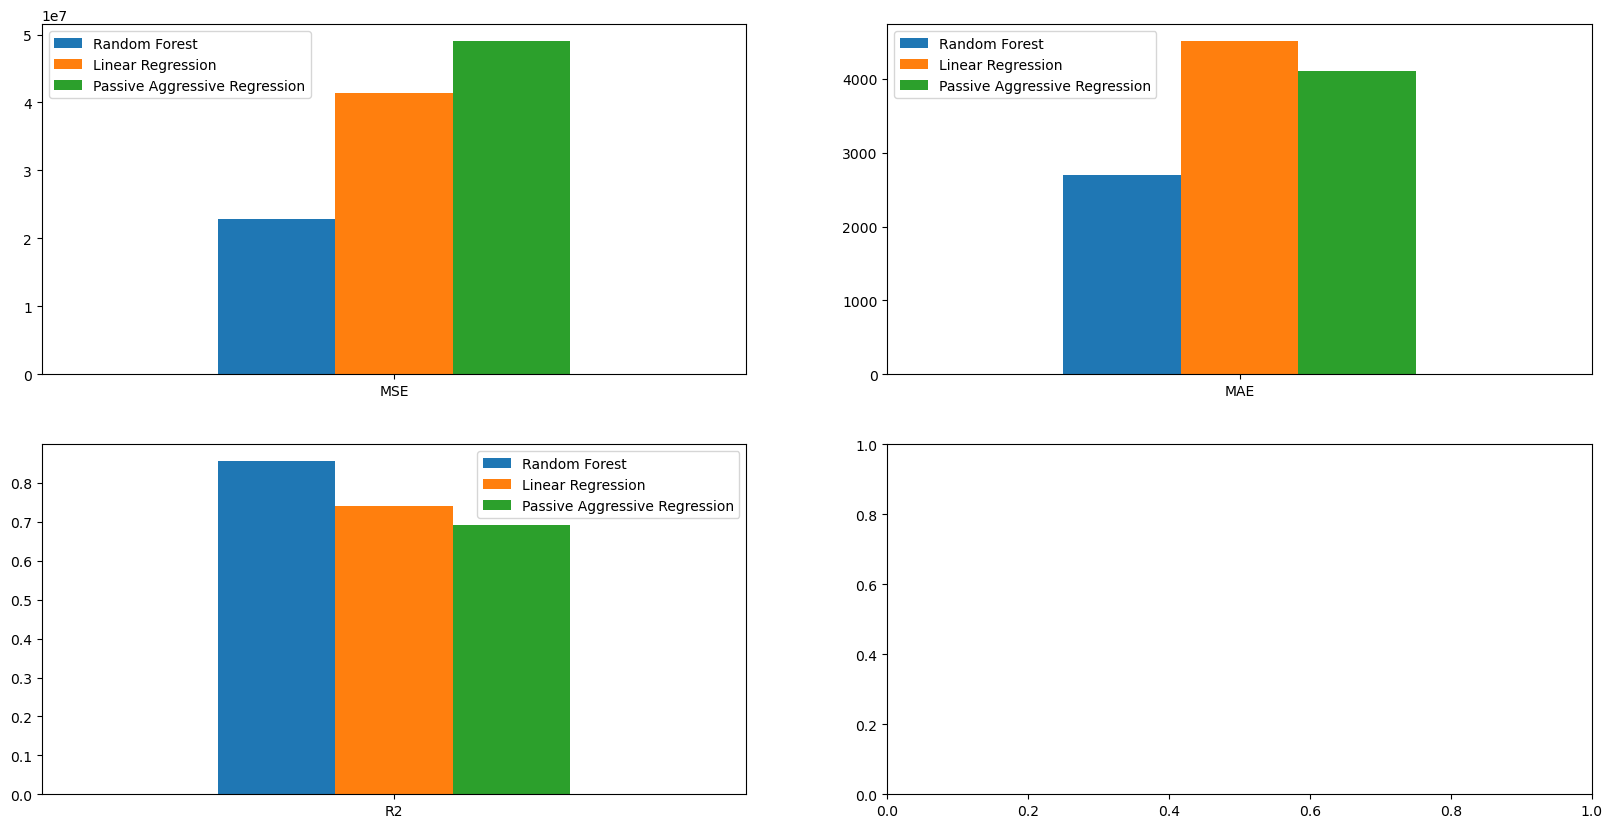

In [25]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse, 'Passive Aggressive Regression': PAR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae, 'Passive Aggressive Regression': PAR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2, 'Passive Aggressive Regression': PAR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
df_mse.plot.bar(rot=0, ax=axes[0][0])
df_mae.plot.bar(rot=0, ax=axes[0][1])
df_r2.plot.bar(rot=0, ax=axes[1][0])

plt.show()

This tests confirms that Random Forest is the better regression model with lower MSE and MAE and higher R2.

## Train a Final Model

Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [26]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

We can also store this model on disk.

In [27]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))